# Captcha Reader menggunakan Photo OCR
Kelompok:
- Ahmed Nizhan Haikal (2110511022)
- Bima Adhitya Sukoco (2110511025)
- Muhammad Teguh Prananto (2110511036)
- Musthofa Dzikry Pamungkas (2110511040)

Notebook ini digunakan untuk membuat model OCR dengan tensorflow. Notebook ini dibuat dalam kaggle notebook karena support GPU nya lebih transparan dibandingkan colab.

Training satu buah model memakan waktu kurang lebih lima jam dengan menggunakan GPU tesla T4 dalam kaggle.

**Notebook ini dijalankan dengan menggunakan GPU sebagai hardware accelerator**.

## Import Dependencies

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import time
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

tf.random.set_seed(42)
print(tf.__version__)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

2.12.0


In [2]:
!nvidia-smi

Tue May 30 07:48:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Persiapan Pengambilan Data

### Mengambil seluruh nama file citra yang akan digunakan beserta dengan labelnya

In [3]:
img_dir = '/kaggle/input/comprasnet-captchas/comprasnet_imagensacerto'
vocab = set()
max_len = 0
# Mengambil label dan jumlah karakter terbanyak dalam label yang berada pada nama file dari masing masing citra
# dan menyimpan label tersebut dalam array.
for file in os.listdir(img_dir):
    if file.endswith('.png'):
        vocab.update(file.split('.')[0])
        max_len = max(max_len, len(file.split('.')[0]))
vocab = "".join(vocab)
vocab, max_len

('YLNFDcxWvquPsEwJSZrmyX49V7AnCG5UkMHBTQ28dgeti6KRj3zafhpb1', 7)

In [5]:
# melihat nama seluruh citra dan menambahkan padding pada label agar seluruh
# label terdiri atas 7 karakter
image_paths, labels = [], []
for filename in os.listdir(img_dir):
    image_paths.append(os.path.join(img_dir, filename))
    label = filename.split('.')[0]
    label = np.array([vocab.index(l) for l in label if l in vocab])
    label = np.pad(label, (0, max_len - len(label)), 'constant', constant_values=len(vocab))
    labels.append(label)

### Training, validation, dan testing split
Seluruh data dibagi menjadi 80% untuk training, 10% untuk validasi, dan 10% untuk testing.

In [6]:
# Mengambil index untuk training, validasi, dan testing
train_idx = int(len(image_paths) * 0.8)
val_idx = int(len(image_paths) * 0.9)
train_idx, val_idx

(52810, 59411)

In [7]:
# Memisahkan antara file dan label citra yang akan digunakan untuk training, validasi, dan testing 
train_images = image_paths[:train_idx]
train_labels = labels[:train_idx]
val_images = image_paths[train_idx:val_idx]
val_labels = labels[train_idx:val_idx]
test_images = image_paths[val_idx:]
test_labels = labels[val_idx:]
len(train_images), len(train_labels), len(val_images), len(val_labels), len(test_images), len(test_labels)

(52810, 52810, 6601, 6601, 6602, 6602)

### Load Data
Seluruh citra yang sudah disimpan namanya akan dimuat dan diubah orientasinya menjadi lebar terlebih dahulu.

In [8]:
# Mengubah path citra tersebut dari list kedalam tensor yang berisi nama file dan labelnya dalam satu index
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Membuat fungsi untuk membaca citra dan merubah orientasinya menjadi lebar terlebih dahulu
def load_and_preprocess_image(image_path, label):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_image(image, channels=1)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.transpose(image, perm=[1, 0, 2]) 
  return image, label

# Load citra dengan menggunakan tensorflow data mapping dan membuat batch serta data tersebut di prefetch agar makin optimal.
train_dataset = train_dataset.map(load_and_preprocess_image)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(load_and_preprocess_image)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(load_and_preprocess_image)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Membuat fungsi untuk decode label
Fungsi ini digunakan untuk merubah kembali label dari bentuk numeriknya menjadi bentuk alfabet.

In [9]:
def decode_label(label, vocab):
  return "".join(vocab[int(i)] for i in label.numpy() if i < len(vocab) and i >= 0)

## Visualisasi beberapa data

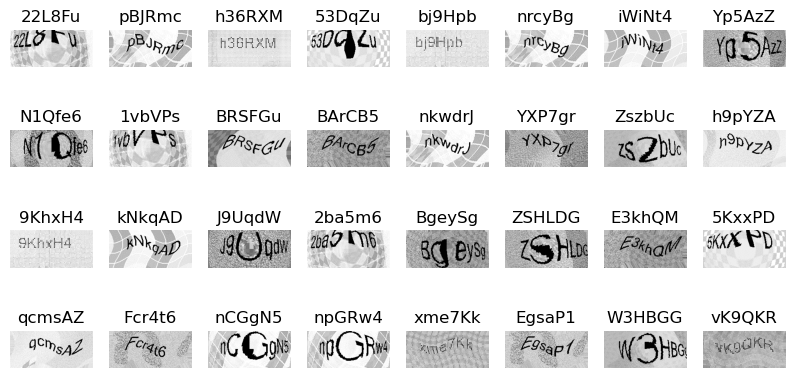

In [10]:
plt.figure(figsize=(10, 5))
for image, label in train_dataset.take(1):
  for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(tf.transpose(image[i][:, :, 0]), 'gray')
    plt.title(f'{decode_label(label[i], vocab)}')
    plt.axis(False);

## Membuat Custom loss function
Model akan dilatih dengan menggunakan CTC loss function, dan karena tensorflow tidak memiliki API untuk secara langsung mendeklarasikan CTC loss function saat kompilasi, maka akan dibuat terlebih dahulu class nya yang menjadi subclass dari loss function tensorflow dan menggunakan method CTC yang terdapat pada tensorflow.

In [11]:
class CTCloss(tf.keras.losses.Loss):
    """ CTCLoss objec for training the model"""
    def __init__(self, name: str = "CTCloss") -> None:
        super(CTCloss, self).__init__()
        self.name = name
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def __call__(self, y_true: tf.Tensor, y_pred: tf.Tensor, sample_weight=None) -> tf.Tensor:
        """ Compute the training batch CTC loss value"""
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)

        return loss

## Membuat custom error metrics

In [12]:
class CERMetric(tf.keras.metrics.Metric):
    """A custom TensorFlow metric to compute the Character Error Rate (CER).
    
    Args:
        vocabulary: A string of the vocabulary used to encode the labels.
        name: (Optional) string name of the metric instance.
        **kwargs: Additional keyword arguments.
    """
    def __init__(self, vocabulary, name="CER", **kwargs):
        # Initialize the base Metric class
        super(CERMetric, self).__init__(name=name, **kwargs)
        
        # Initialize variables to keep track of the cumulative character/word error rates and counter
        self.cer_accumulator = tf.Variable(0.0, name="cer_accumulator", dtype=tf.float32)
        self.batch_counter = tf.Variable(0, name="batch_counter", dtype=tf.int32)
        
        # Store the vocabulary as an attribute
        self.vocabulary = tf.constant(list(vocabulary))

    @staticmethod
    def get_cer(pred_decoded, y_true, vocab, padding=-1):
        """ Calculates the character error rate (CER) between the predicted labels and true labels for a batch of input data.
        Args:
            pred_decoded (tf.Tensor): The predicted labels, with dtype=tf.int32, usually output from tf.keras.backend.ctc_decode
            y_true (tf.Tensor): The true labels, with dtype=tf.int32
            vocab (tf.Tensor): The vocabulary tensor, with dtype=tf.string
            padding (int, optional): The padding token when converting to sparse tensor. Defaults to -1.
        Returns:
            tf.Tensor: The CER between the predicted labels and true labels
        """
        # Keep only valid indices in the predicted labels tensor, replacing invalid indices with padding token
        vocab_length = tf.cast(tf.shape(vocab)[0], tf.int64)
        valid_pred_indices = tf.less(pred_decoded, vocab_length)
        valid_pred = tf.where(valid_pred_indices, pred_decoded, padding)

        # Keep only valid indices in the true labels tensor, replacing invalid indices with padding token
        y_true = tf.cast(y_true, tf.int64)
        valid_true_indices = tf.less(y_true, vocab_length)
        valid_true = tf.where(valid_true_indices, y_true, padding)

        # Convert the valid predicted labels tensor to a sparse tensor
        sparse_pred = tf.RaggedTensor.from_tensor(valid_pred, padding=padding).to_sparse()

        # Convert the valid true labels tensor to a sparse tensor
        sparse_true = tf.RaggedTensor.from_tensor(valid_true, padding=padding).to_sparse()

        # Calculate the normalized edit distance between the sparse predicted labels tensor and sparse true labels tensor
        distance = tf.edit_distance(sparse_pred, sparse_true, normalize=True)

        return distance

    def update_state(self, y_true, y_pred, sample_weight=None):
        """Updates the state variables of the metric.
        Args:
            y_true: A tensor of true labels with shape (batch_size, sequence_length).
            y_pred: A tensor of predicted labels with shape (batch_size, sequence_length, num_classes).
            sample_weight: (Optional) a tensor of weights with shape (batch_size, sequence_length).
        """
        # Get the input shape and length
        input_shape = tf.keras.backend.shape(y_pred)
        input_length = tf.ones(shape=input_shape[0], dtype="int32") * tf.cast(input_shape[1], "int32")

        # Decode the predicted labels using greedy decoding
        decode_predicted, log = tf.keras.backend.ctc_decode(y_pred, input_length, greedy=True)

        # Calculate the normalized edit distance between the predicted labels and true labels tensors
        distance = self.get_cer(decode_predicted[0], y_true, self.vocabulary)

        # Add the sum of the distance tensor to the cer_accumulator variable
        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        
        # Increment the batch_counter by the batch size
        self.batch_counter.assign_add(len(y_true))

    def result(self):
        """ Computes and returns the metric result.
        Returns:
            A TensorFlow float representing the CER (character error rate).
        """
        return tf.math.divide_no_nan(self.cer_accumulator, tf.cast(self.batch_counter, tf.float32))

## Pembuatan Model
Model dibuat dengan menggunakan functional API dari tensorflow dan dicompile dengan menggunakan Adam optimizer, CTCloss function dan CERmetrics.

In [13]:
def make_model(input_shape, max_sequence_length, num_characters):
  encoder_inputs = layers.Input(
        shape=input_shape, name="image", dtype="float32"
    )
  encoder = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_inputs)
  encoder = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder)
  encoder = layers.MaxPooling2D((2, 2))(encoder)
  encoder = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder)
  encoder = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder)
  encoder = layers.MaxPooling2D((2, 2))(encoder)
  encoder = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder)
  encoder = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder)
  encoder = layers.MaxPooling2D((2, 2))(encoder)
  encoder = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder)
  encoder = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder)
  encoder = layers.MaxPooling2D((2, 2))(encoder)
  encoder = layers.BatchNormalization()(encoder)
  new_shape = ((input_shape[0] // 16), (input_shape[1] // 16) * 32)
  encoder = layers.Reshape(new_shape)(encoder)
  encoder = layers.Dense(64, activation='relu')(encoder)
  encoder = layers.Dense(128, activation='relu')(encoder)
  encoder_outputs = layers.Dropout(0.2)(encoder)

  decoder_inputs = layers.GRU(128, return_sequences=True, dropout=0.25)(encoder_outputs)
  decoder_outputs = layers.Dense(num_characters + 1, activation='softmax')(decoder_inputs)
  
  model = tf.keras.Model(encoder_inputs, decoder_outputs)

  model.compile(optimizer='adam', loss=CTCloss(), metrics=[CERMetric(vocab)])
  return model

## Membuat model dengan menggunakan fungsi yang sudah dibuat.

In [14]:
input_shape = (200, 90, 1)
model = make_model(input_shape, max_len, len(vocab))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 90, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 200, 90, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 90, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 45, 32)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 45, 32)       9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 45, 32)       9248      
                                                             

## Model Training
Model akan dilatih dengan menggunakan earlystopping callback dan setelah selesai akan menampilkan grafik loss terhadap epoch dari model pada saat training.

Epoch 1/1000
1651/1651 [==============================] - 333s 193ms/step - loss: 23.8533 - CER: 0.9440 - val_loss: 25.4968 - val_CER: 0.9571
Epoch 2/1000
1651/1651 [==============================] - 96s 58ms/step - loss: 22.0720 - CER: 0.8791 - val_loss: 21.5486 - val_CER: 0.8434
Epoch 3/1000
1651/1651 [==============================] - 98s 59ms/step - loss: 21.4325 - CER: 0.8342 - val_loss: 21.1915 - val_CER: 0.8223
Epoch 4/1000
1651/1651 [==============================] - 99s 60ms/step - loss: 21.2045 - CER: 0.8225 - val_loss: 21.0807 - val_CER: 0.8193
Epoch 5/1000
1651/1651 [==============================] - 99s 60ms/step - loss: 21.0774 - CER: 0.8178 - val_loss: 21.0170 - val_CER: 0.8168
Epoch 6/1000
1651/1651 [==============================] - 102s 62ms/step - loss: 20.9647 - CER: 0.8142 - val_loss: 21.0917 - val_CER: 0.8238
Epoch 7/1000
1651/1651 [==============================] - 99s 60ms/step - loss: 20.8315 - CER: 0.8106 - val_loss: 20.7128 - val_CER: 0.8095
Epoch 8/1000
1651

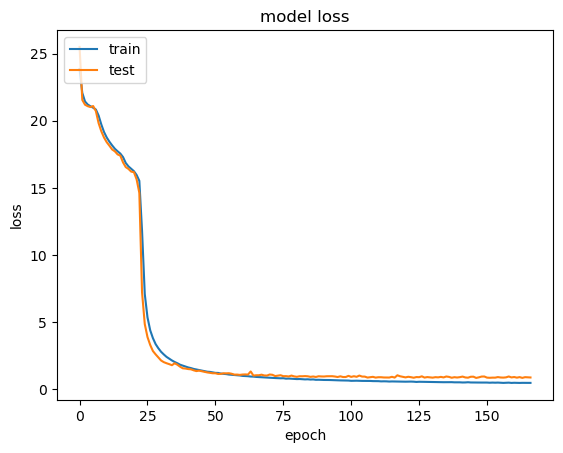

In [15]:
epochs = 1000
early_stopping_patience = 20
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

start_time = time.time()
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)
print("--- %s seconds ---" % (time.time() - start_time))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Visualisasi Error Rate dari model yang sudah dilatih

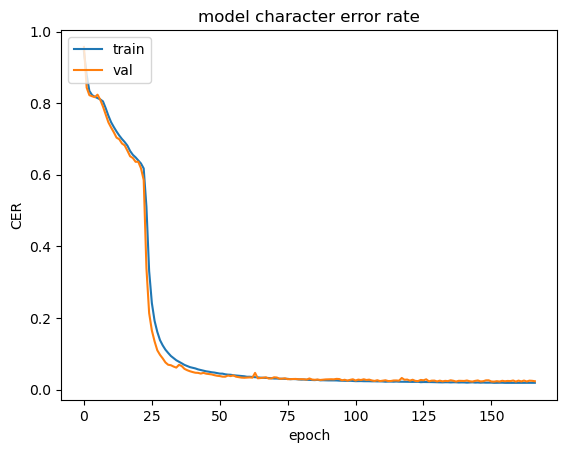

In [16]:
plt.plot(history.history['CER'])
plt.plot(history.history['val_CER'])
plt.title('model character error rate')
plt.ylabel('CER')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluasi model pada data testing

In [17]:
print(model.evaluate(test_dataset))

207/207 [==============================] - 34s 166ms/step - loss: 0.8150 - CER: 0.0232
[0.8150156736373901, 0.023182010278105736]


## Mencoba memprediksi beberapa sample dari test dataset

1/1 [==============================] - 0s 439ms/step


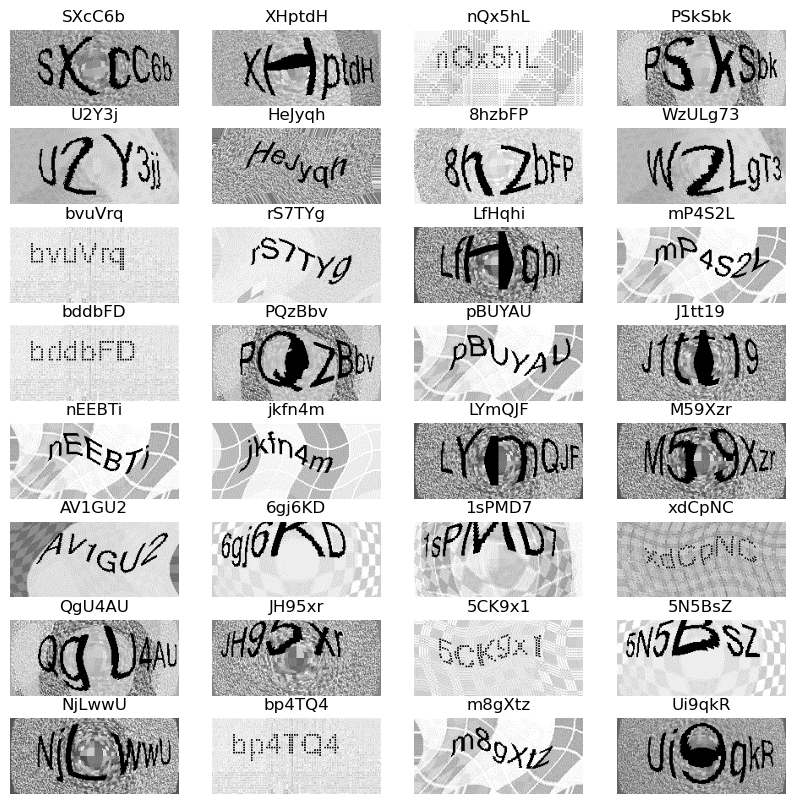

In [18]:
plt.figure(figsize=(10, 10))
for image, label in test_dataset.take(1):
    # Prediksi pada citra
    preds = model.predict(image)
    # Membuat array dengan ukuran sama dengan hasil prediksi
    input_len = np.ones(preds.shape[0]) * preds.shape[1]
    # Mengkonversi hasil dari output dengan menggunakan ctc_decode kedalam probabilitas dan mengambil
    # sebanyak karakter terpanjang dari data training.
    results = keras.backend.ctc_decode(preds, input_length=input_len, greedy=True)[0][0][:, :max_len]
    output_text = []
    # Mengkonversi probabilitas tersebut menjadi bentuk alfabet dengan menggunakan fungsi yang dibuat sebelumnya.
    for res in results:
        res = tf.strings.reduce_join(decode_label(res, vocab)).numpy().decode("utf-8")
        output_text.append(res)
    # Plot citra dengan label prediksi sebagai title atau judul dari masing masing citra.
    for i in range(32):
        plt.subplot(8, 4, i + 1)
        plt.imshow(tf.transpose(image[i, :, :, 0]), 'gray')
        plt.title(f'{output_text[i]}')
        plt.axis(False);

## Menyimpan model

In [19]:
model.save('raw_model')

In [20]:
!zip -r raw_model.zip /kaggle/working/raw_model

  adding: kaggle/working/raw_model/ (stored 0%)
  adding: kaggle/working/raw_model/saved_model.pb (deflated 89%)
  adding: kaggle/working/raw_model/assets/ (stored 0%)
  adding: kaggle/working/raw_model/keras_metadata.pb (deflated 94%)
  adding: kaggle/working/raw_model/fingerprint.pb (stored 0%)
  adding: kaggle/working/raw_model/variables/ (stored 0%)
  adding: kaggle/working/raw_model/variables/variables.data-00000-of-00001 (deflated 14%)
  adding: kaggle/working/raw_model/variables/variables.index (deflated 71%)


In [21]:
model.save('raw_model.h5')

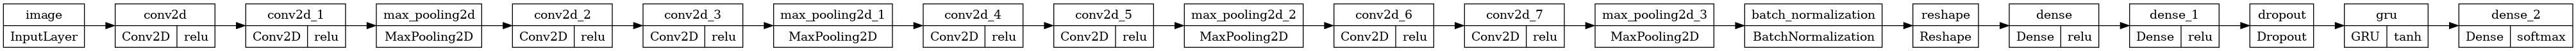

In [22]:
tf.keras.utils.plot_model(model, 'raw_model.png', show_layer_activations=True, expand_nested=True, rankdir='LR')

## Add Preprocessing
Model dengan arsitektur yang sama akan dicoba dilatih kembali dengan menggunakan data yang sudah dilakukan tahap pengolahan citra.

In [23]:
# Membuat directory baru untuk menyimpan citra yang sudah di olah.
!mkdir preprocessed_images

### Melakukan pengolahan citra
Pengolahan citra yang digunakan memiliki tahap sebagai berikut:
1. Baca citra dengan format grayscale
2. Membuat border pada seluruh sisi citra
3. Melakukan thresholding dengan metode binary inverse
4. Denoising dengan menggunakan contour
5. Morfologi opening
Seluruh citra yang sudah melewati tahap tersebut akan disimpan pada folder yang sudah dibuat sebelumnya dengan namanya filenya sebagai label.

In [24]:
# Melakukan pengolahan citra
def preprocess_image(data_dir):
    # Pembuatan kenel untuk opening
    kernel = np.ones((2, 2), np.uint8)
    for dir in os.listdir(data_dir):
        # Baca citra
        image = cv2.imread(os.path.join(data_dir, dir), 0)
        if image is not None:
            # Membuat border
            image = cv2.copyMakeBorder(image, 5, 5, 5, 5, cv2.BORDER_REPLICATE)
            # Image Thresholding
            image = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY_INV)[1]
            # Menghitung seluruh contour pada citra
            contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            # Mendefinisikan area minimal untuk dikategorikan sebagai bukan noise
            min_contour_area = .9
            # Melakukan filtering berdasarkan area dari contour
            filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
            # Membuat masking
            mask = np.zeros_like(image)
            # Menaruh contour yang bukan noise pada masking
            cv2.drawContours(mask, filtered_contours, -1, (255), thickness=cv2.FILLED)
            # Bitwise and untuk menghilangkan seluruh bagian dari citra yang tidak diisi pada masking
            image = cv2.bitwise_and(image, mask)
            # Morfologi Opening
            image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
            # Menyimpan citra pada folder yang sudah dibuat
            cv2.imwrite(f'/kaggle/working/preprocessed_images/{dir}', image)

preprocess_image('/kaggle/input/comprasnet-captchas/comprasnet_imagensacerto')

### Persiapan Pengambilan Data
Menyimpan seluruh nama file yang akan digunakan dan menambahkan padding pada label agar seluruh label memiliki panjang yang sama.

In [25]:
img_dir = '/kaggle/working/preprocessed_images'
image_paths, labels = [], []
for filename in os.listdir(img_dir):
    image_paths.append(os.path.join(img_dir, filename))
    label = filename.split('.')[0]
    label = np.array([vocab.index(l) for l in label if l in vocab])
    label = np.pad(label, (0, max_len - len(label)), 'constant', constant_values=len(vocab))
    labels.append(label)

### Training, validation, testing split
Pemisahan data dilakukan dengan menggunakan metode yang sama yaitu 80% untuk training, 10% untuk validasi, dan 10% lagi untuk testing.

In [26]:
train_idx = int(len(image_paths) * 0.8)
val_idx = int(len(image_paths) * 0.9)
train_idx, val_idx

(52810, 59411)

In [27]:
train_images = image_paths[:train_idx]
train_labels = labels[:train_idx]
val_images = image_paths[train_idx:val_idx]
val_labels = labels[train_idx:val_idx]
test_images = image_paths[val_idx:]
test_labels = labels[val_idx:]
len(train_images), len(train_labels), len(val_images), len(val_labels), len(test_images), len(test_labels)

(52810, 52810, 6601, 6601, 6602, 6602)

### Load Data
Nama file yang sudah disimpan kemudian akan dibaca citranya dan diubah orientasinya menjadi lebar terlebih dahulu.

In [28]:
# Mengubah list menjadi tensorflow data format yang berisi nama file dan labelnya pada satu index.
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
# Membuat fungsi untuk membaca citra
def load_and_preprocess_image(image_path, label):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_image(image, channels=1)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.transpose(image, perm=[1, 0, 2]) 
  return image, label

# Membaca citra berdasarkan nama path atau nama filenya, kemudian dijadikan batch dengan ukuran 32, diprefetch datanya dan kemudian datanya di cache untuk 
# mempersingkat waktu training.
train_dataset = train_dataset.map(load_and_preprocess_image)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE).cache()
val_dataset = val_dataset.map(load_and_preprocess_image)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE).cache()
test_dataset = test_dataset.map(load_and_preprocess_image)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Membuat fungsi decode label
Membuat fungsi untuk mengubah label dari bentuk numerik menjadi bentuk alfabet kembali.

In [29]:
def decode_label(label, vocab):
  return "".join(vocab[int(i)] for i in label.numpy() if i < len(vocab) and i >= 0)

### Visualisasi Data

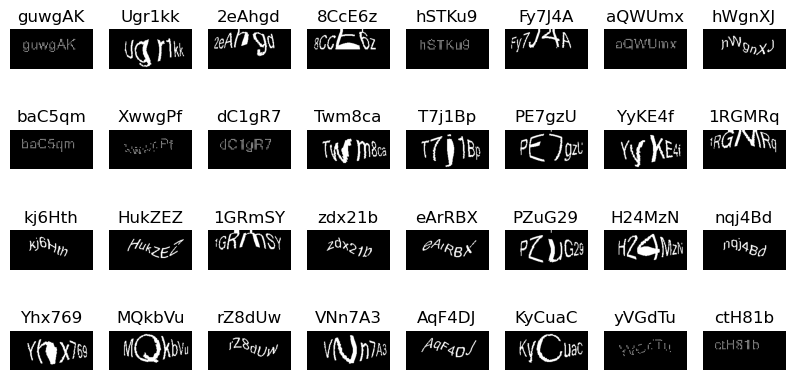

In [30]:
plt.figure(figsize=(10, 5))
for image, label in train_dataset.take(1):
  for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(tf.transpose(image[i][:, :, 0]), 'gray')
    plt.title(f'{decode_label(label[i], vocab)}')
    plt.axis(False);

### Membuat model
Konfigurasi model yang digunakan sama sepeti sebelumnya, yang berbeda hanya ukuran dari inputnya saja karena ditambahkan border.

In [31]:
input_shape = (210, 100, 1)
preprocessed_model = make_model(input_shape, max_len, len(vocab))
preprocessed_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 210, 100, 1)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 210, 100, 32)      320       
                                                                 
 conv2d_9 (Conv2D)           (None, 210, 100, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 105, 50, 32)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 105, 50, 32)       9248      
                                                                 
 conv2d_11 (Conv2D)          (None, 105, 50, 32)       9248      
                                                           

### Model Training
Model akan dilatiha dengan menggunakan earlystopping callback, setelah training selesai akan ditampilkan grafik kurva loss model terhadap epoch dalam masa training.

Epoch 1/1000
1651/1651 [==============================] - 90s 51ms/step - loss: 23.9189 - CER: 0.9310 - val_loss: 22.2558 - val_CER: 0.8637
Epoch 2/1000
1651/1651 [==============================] - 63s 38ms/step - loss: 21.9977 - CER: 0.8573 - val_loss: 21.5673 - val_CER: 0.8435
Epoch 3/1000
1651/1651 [==============================] - 73s 44ms/step - loss: 21.4605 - CER: 0.8436 - val_loss: 21.1279 - val_CER: 0.8350
Epoch 4/1000
1651/1651 [==============================] - 63s 38ms/step - loss: 20.0970 - CER: 0.8132 - val_loss: 18.1453 - val_CER: 0.7571
Epoch 5/1000
1651/1651 [==============================] - 62s 37ms/step - loss: 17.3254 - CER: 0.7270 - val_loss: 16.2239 - val_CER: 0.6773
Epoch 6/1000
1651/1651 [==============================] - 63s 38ms/step - loss: 15.3509 - CER: 0.6590 - val_loss: 12.8260 - val_CER: 0.5734
Epoch 7/1000
1651/1651 [==============================] - 74s 45ms/step - loss: 11.7455 - CER: 0.5397 - val_loss: 8.6615 - val_CER: 0.4207
Epoch 8/1000
1651/165

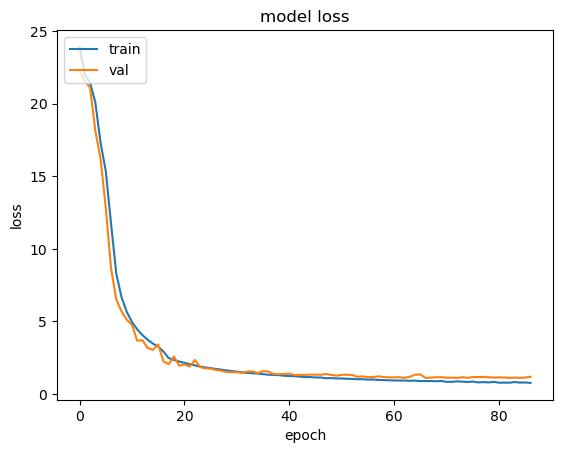

In [32]:
epochs = 1000
early_stopping_patience = 20
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
start_time = time.time()
history = preprocessed_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)
print("--- %s seconds ---" % (time.time() - start_time))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


### Visualisasi CER
Visualisasi kurva character error rate dari model pada saat training.

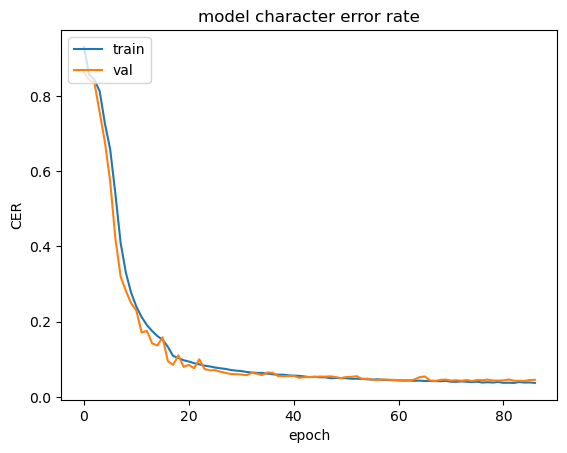

In [33]:
plt.plot(history.history['CER'])
plt.plot(history.history['val_CER'])
plt.title('model character error rate')
plt.ylabel('CER')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluasi model pada data testing

In [34]:
preprocessed_model.evaluate(test_dataset)

207/207 [==============================] - 7s 34ms/step - loss: 1.1283 - CER: 0.0440


[1.1282625198364258, 0.04400181770324707]

### Test prediksi model
Test prediksi model terhadap satu buah batch dataset dan memvisualisasikan hasil prediksinya sebagai title dari masing masing citra.

1/1 [==============================] - 0s 415ms/step


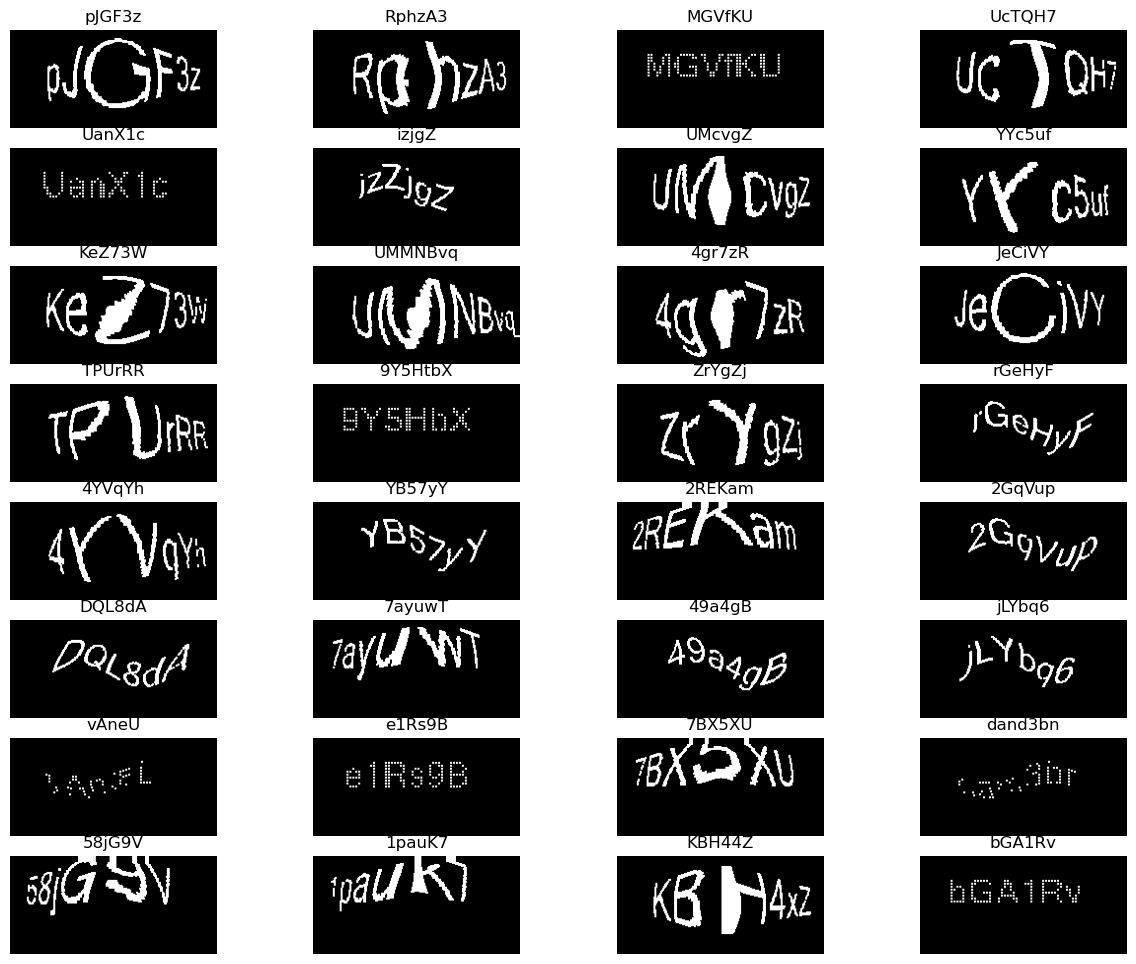

In [35]:
plt.figure(figsize=(15, 12))
for image, label in test_dataset.take(1):
    # Prediksi Model
    preds = preprocessed_model.predict(image)
    # Membuat array seukuran hasil prediksi
    input_len = np.ones(preds.shape[0]) * preds.shape[1]
    # Mengubah bentuk output menjadi bentuk probabilitas menggunakan ctc_decode
    results = keras.backend.ctc_decode(preds, input_length=input_len, greedy=True)[0][0][:, :max_len]
    output_text = []
    for res in results:
        # Mengubah bentuk index tersebut menjadi bentuk alfabet kembali dengan menggunakan fungsi yang dibuat sebelumnya
        res = tf.strings.reduce_join(decode_label(res, vocab)).numpy().decode("utf-8")
        # Menyimpan hasilnya pada sebuah list
        output_text.append(res)
    # Visualisasi hasil
    for i in range(32):
        plt.subplot(8, 4, i + 1)
        plt.imshow(tf.transpose(image[i, :, :, 0]), 'gray')
        plt.title(f'{output_text[i]}')
        plt.axis(False);

### Save Model

In [36]:
preprocessed_model.save('/kaggle/working/preprocessed_model')

In [37]:
!zip -r preprocessed_model.zip /kaggle/working/preprocessed_model

  adding: kaggle/working/preprocessed_model/ (stored 0%)
  adding: kaggle/working/preprocessed_model/saved_model.pb (deflated 89%)
  adding: kaggle/working/preprocessed_model/assets/ (stored 0%)
  adding: kaggle/working/preprocessed_model/keras_metadata.pb (deflated 94%)
  adding: kaggle/working/preprocessed_model/fingerprint.pb (stored 0%)
  adding: kaggle/working/preprocessed_model/variables/ (stored 0%)
  adding: kaggle/working/preprocessed_model/variables/variables.data-00000-of-00001 (deflated 11%)
  adding: kaggle/working/preprocessed_model/variables/variables.index (deflated 71%)


In [38]:
preprocessed_model.save('/kaggle/working/preprocessed_model.h5')